In [7]:
# import the necessary packages
import os

import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import (AveragePooling2D, Dense, Dropout, Flatten,
                                     Input)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array, load_img)
from tensorflow.keras.utils import to_categorical


In [8]:

# initialize the initial learning rate
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# For Linux
# DIRECTORY = r"/home/apple/Desktop/Face_Mask_Project/dataset/"

DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]


In [9]:

# grab the list of images in our dataset directory, then initialize
print("[INFO] loading images...")

data = []
labels = []


[INFO] loading images...


C:\Anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9420800/9406464 [==============================] - 2s 0us/step
Compilation of the MODEL is going on...
Training Head Started...


C:\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 66s 665ms/step - loss: 0.3757 - accuracy: 0.8530 - val_loss: 0.1205 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 59s 624ms/step - loss: 0.1379 - accuracy: 0.9618 - val_loss: 0.0642 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 59s 623ms/step - loss: 0.0937 - accuracy: 0.9730 - val_loss: 0.0477 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 61s 637ms/step - loss: 0.0728 - accuracy: 0.9789 - val_loss: 0.0415 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 63s 664ms/step - loss: 0.0658 - accuracy: 0.9822 - val_loss: 0.0372 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 71s 751ms/step - loss: 0.0498 - accuracy: 0.9858 - val_loss: 0.0366 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 63s 664ms/step - loss: 0.0548 - accuracy: 0.9819 - val_loss: 0.0315 - val_accuracy: 0.9922

C:\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


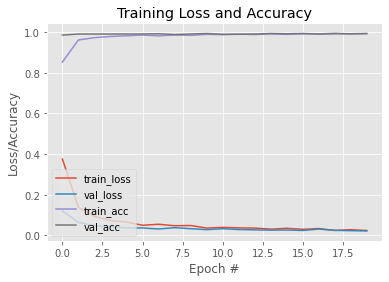

In [10]:

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

# convert text to Binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Create head and the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Call head and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
	layer.trainable = False

# compile our model 17
print("Compilation of the MODEL is going on...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("Training Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("Network evaluation...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
